# Testing Fetal Signal Specificity
Specificity is usually defined as the ratio between desired signal and undesired/background/noise signal. For our case, the desired signal is going to be the fetal signal while the undesired signal is the maternal pulsation.

## First Try
We can go ahead and use the same simplification of sensitivity to get specificity as 
$$
specificity_1 = \frac{\int I(L) log(R_{fetal}(L)) dL}{\int I(L)dL} / \frac{\int I(L) log(R_{maternal}(L))dL}{\int I(L)dL} = \frac{\int I(L) log(R_{fetal}(L))dL}{\int I(L) log(R_{maternal}(L))dL}
$$


In [15]:
from typing import Callable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2
from inverse_modelling_tfo.tools.optical_properties import get_tissue_mu_a
from tfo_sensitivity.data import load_raw
from tfo_sensitivity.tof import ToF, two_pointer_discrete_optimize, two_pointer_brute_force_optimize

wave_int = 2
data_path = r'/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil/fa_pulse_wv_2_sa_0.1_ns_1_ms_4_ut_5.pkl'
raw_sim_data = pd.read_pickle(data_path)
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - raw_sim_data['Y']
all_sdd = raw_sim_data['SDD'].unique()

MATERNAL_Hb = 11.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.50
FETAL_Hb = 11.0
DELTA = 0.01
SDD_index = 1
BLOOD_VOLUME_FRACTION = 0.1

data_table = pd.DataFrame(columns=['Saturation', 'Derivative', 'SDD', 'Type'])
all_c = np.arange(0.1, 1.5, 0.1)
all_fetal_sat = np.arange(0.1, 0.65, 0.2)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

modified_mu_map_base = base_mu_map.copy()
modified_mu_map_base[1] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map_base[4] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, FETAL_SAT, FETAL_Hb, wave_int)

modified_mu_map_increased = base_mu_map.copy()
modified_mu_map_increased[1] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map_increased[4] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, FETAL_SAT , FETAL_Hb + DELTA, wave_int)

modified_mu_map_mom_increased = base_mu_map.copy()
modified_mu_map_mom_increased[1] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, MATERNAL_SAT, MATERNAL_Hb + DELTA, wave_int)
modified_mu_map_mom_increased[4] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, FETAL_SAT , FETAL_Hb, wave_int)

filtered_photon_data  = (raw_sim_data[raw_sim_data["SDD"] == all_sdd[SDD_index]]).copy()

## Setup Constants

In [16]:
# Use the new brute force optimization instead. The two pointer one sometimes gets stuck at a local optima
TIME_RESOLUTION = 0.2e-9
lower_intensity_bound = 1e-30
tof_base = ToF(filtered_photon_data, TIME_RESOLUTION, modified_mu_map_base, SDD_index, lower_intensity_bound)
tof_increased = ToF(filtered_photon_data, TIME_RESOLUTION, modified_mu_map_increased, SDD_index, lower_intensity_bound)
tof_increased_mom = ToF(
    filtered_photon_data, TIME_RESOLUTION, modified_mu_map_mom_increased, SDD_index, lower_intensity_bound
)

# Sensitivty & Specificity Definitions

In [21]:
# All functions in this block return a callable, which takes the left and right time bins and produces a figure of merit
output_type = Callable[[int, int], float]


# 1 Sensitivity x SNR
def sensitivity_times_snr(base_tof: ToF, increased_tof: ToF) -> output_type:
    """
    Figure of Merit = Fetal Sensitivity(approx. term) * SNR (Sensed Intensity)
    """
    RL = base_tof / increased_tof
    numerator = np.abs(np.log(RL.data)) * base_tof.data
    return lambda left, right: numerator.iloc[left : right + 1].sum()


def threshold_snr(base_tof: ToF, increased_tof: ToF, threshold_prct: float) -> output_type:
    """
    Figure of Merit = Fetal Sensitivity(approx. term) * (SNR >= threshold)
    The second term in the equation is a boolean mask. The logic being that if the SNR is below a certain threshold, it
    does not make sense to improve it any further.
    :param threshold_prct: Threshold of the SNR wrt the maximum possible SNR(i.e,CW Intensity or max possible intensity)
    """
    RL = base_tof / increased_tof
    numerator = np.abs(np.log(RL.data)) * base_tof.data
    denominator = base_tof.data
    return (
        lambda left, right: numerator.iloc[left : right + 1].sum()
        / denominator.iloc[left : right + 1].sum()
        * (denominator.iloc[left : right + 1].sum() / denominator.sum() >= threshold_prct)
    )

## Applying Definition

In [31]:
# Note: Operator overloading takes care of bin count mismatch/missing bins etc. When working with two ToF, its better to use the overloaded operators
RL_fetal = tof_base / tof_increased
RL_mom = tof_base / tof_increased_mom
numerator = np.abs(np.log(RL_fetal.data)) * tof_base.data
denominator = np.abs(np.log(RL_mom.data)) * tof_base.data

# Specificty definition 2 - fetal sensitivity by maternal sensitivity
# target_func = lambda left, right: numerator.iloc[left: right + 1].sum() / denominator.iloc[left: right + 1].sum()
# Speicificty times signal SNR
# target_func = lambda left, right: numerator.iloc[left: right + 1].sum() / denominator.iloc[left: right + 1].sum() * tof_base.data.iloc[left: right + 1].sum()
# Divide each point by its maternal pathlength -> Something analogous to Specificity
# target_func = lambda left, right: (numerator.iloc[left: right + 1] / np.log(RL_mom.data.iloc[left: right + 1])).sum()
# Divide each point by the exponent of its maternal pathlength
# target_func = lambda left, right: (numerator.iloc[left: right + 1] / RL_mom.data.iloc[left: right + 1]).sum()
# target_func = sensitivity_times_snr(tof_base, tof_increased)
target_func = threshold_snr(tof_base, tof_increased, 0.05)

left, right, tof_optimum = two_pointer_brute_force_optimize(target_func, 0, len(tof_base.data) - 1, "max")
print("Data Length", len(numerator))

# print("RL data", RL.data)
print(left, right, tof_optimum)

Data Length 128
2 97 5.363013892655361e-05


## Plotting the Numerator and Denominator Values

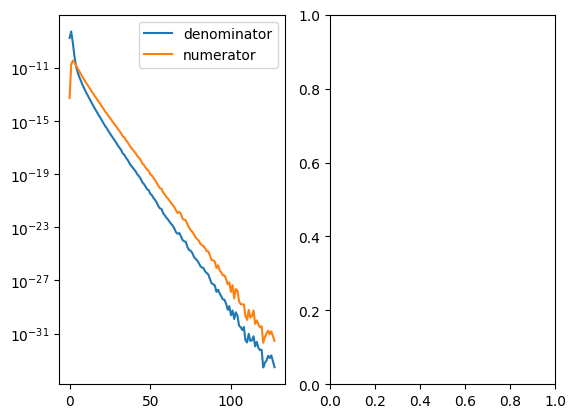

In [32]:
fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plt.plot(denominator, label='denominator')
plt.plot(numerator, label='numerator')
plt.yscale('log')
plt.legend()

## Plotting HeatMap

Improvement Ratio 11.259876799373993


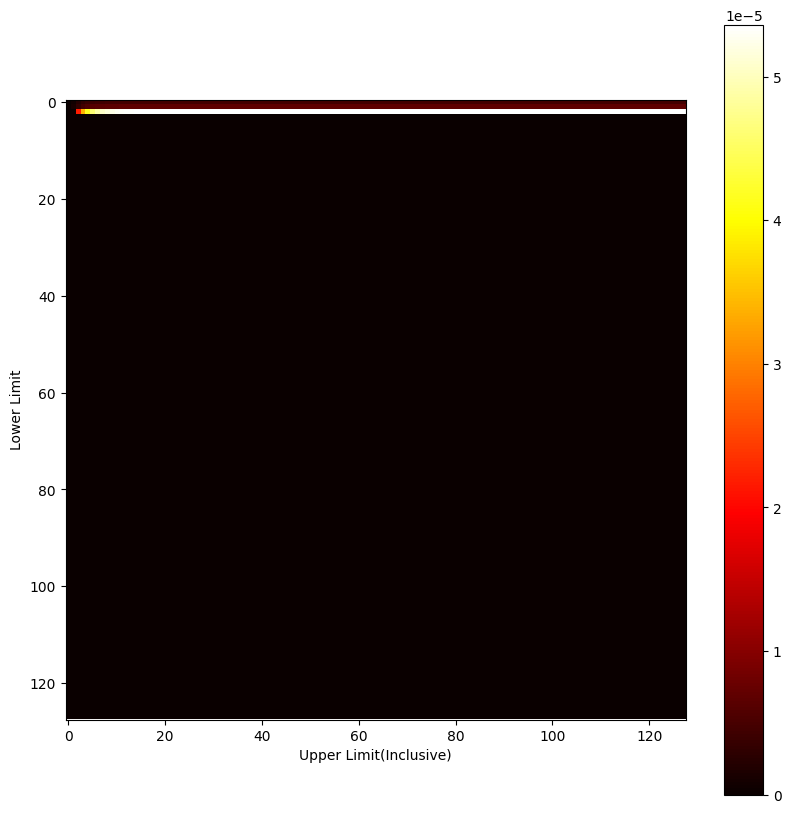

In [33]:
# Brute Force Optimization
plt.figure(figsize=(10, 10))
target_func_matrix = np.zeros((len(tof_base.data), len(tof_base.data)))
for i in range(len(tof_base.data)):
    for j in range(i, len(tof_base.data)):
        target_func_matrix[i, j] = target_func(i, j)
# target_func_matrix = np.abs(np.log(target_func_matrix))
plt.imshow(target_func_matrix, cmap='hot', interpolation='none')
plt.xlabel('Upper Limit(Inclusive)')
plt.ylabel('Lower Limit')
plt.colorbar()

# Improvememnt ratio : Tof / CW
cw_optimum = target_func_matrix[0, -1]  # Top-right edge of the matrix
imrovement_ratio = tof_optimum / cw_optimum
print('Improvement Ratio', imrovement_ratio)